In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [194]:
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "rbf" : "b", "LReg" : "o", "combined" : "g"}
kernel_alpha = {"linear" : 1/3, "rbf" : 2/3, "LReg" : "o", "combined" : "g"}
kernels = ["linear", "rbf"]
direction_colors = ["r", "b"]
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [9, 8]
method_markers = ["o", "."]
marker_meaning = {9 : "forward", 8 : "backwards"}
normalized = {True : "_std", False: ""}
alpha_norm = {True : 1/2, False: 1}
std = ["standardised", "original"]

In [75]:
def find_similar_pairs(df):
    unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False))) 
    similar_pairs = sort_similar_pairs(unique_pairs_df)
    return similar_pairs

def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
#     regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
#     model_type_match = (df.model.str.contains(regex_model_types, regex=True))
#     forward_df = df.loc[forward_match & model_type_match]
#     backward_df = df.loc[backward_match & model_type_match]    
    forward_df = df.loc[forward_match]
    backward_df = df.loc[backward_match]
    return {str((pair[0], pair[1])) : forward_df, str((pair[1], pair[0])) : backward_df}

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [14]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(data):
#     stats = {}
    for experiment in range(1,4):
        with PdfPages(f'results/figures/experiment_{experiment}{normalized[data["std"].values[0]]}.pdf') as pdf:
            print(f"Experiment {experiment}")
            experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
            df = data.loc[data.experiment==experiment]
            similar_pairs = find_similar_pairs(df)
            pair_dfs = [get_pair_df(pair, df) for pair in similar_pairs[::2]]

            n_pairs = len(pair_dfs)

            xlabel = "Discrepancy"
            ylabel = "Coefficient of Determination"

            for pair_index in range(n_pairs):
                forward_pair, backward_pair = pair_dfs[pair_index].keys()
                forward_df, backward_df = pair_dfs[pair_index].values()
                pair_df = pd.concat([forward_df, backward_df])

                fig, axs = plt.subplots(nrows = 1, ncols = 1, sharey="row", sharex= "row", figsize= (6, 6))
                fig.suptitle(forward_pair, fontsize =13)
                fig.tight_layout(pad=6)

                experiment_stats.loc[forward_pair] = forward_df.discrepancy.describe().values.T
                experiment_stats.loc[backward_pair] = backward_df.discrepancy.describe().values.T

                for row in pair_df.itertuples(index=False):
                    model_type = row.kernel
                    color = kernel_colors[model_type]
                    x, y = round(row.discrepancy,2), round(row.model_r2,2)

                    if row.model_node < row.test_node:
                        direction = 0
                    else:
                        direction = 1 

                    axs.plot(x, y, color, alpha = alpha_norm[row.std], marker = method_markers[0])
                    axs.plot(x, y, color, alpha = alpha_norm[row.std], marker = direction_markers[direction])
                    axs.plot(x, y, "w", alpha = 0.8, marker = method_markers[1])
                    axs.plot([0,x],[y-x,y], color, alpha = 0.3, linestyle = (0, (1, 1)))

                axs.set_ylabel(ylabel)
                axs.set_xlabel(xlabel)
                axs.set_ylim([0,1.1])
#                 axs.set_xlim([0,1.0])
                x, y = [x], [y]
                
                usability_line = axs.plot([0,1.1],[0,1.1],c = "g", linestyle= "--", alpha=0.5)
                kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 1, linewidth=5) for k in ["linear","rbf"]]
                std_lines = [Line2D(x, y, c= "b", alpha = alpha_norm[True], linewidth=5)]
                
                threshold_lines = []
                forward_direction_line = Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = 9, linewidth = 0)
                backward_direction_line = Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = 8, linewidth = 0)
                inner_point = Line2D(x, y, c= "w", alpha = 0.8, marker = method_markers[1], linewidth = 0)

                threshold_lines.append((Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = method_markers[0], linewidth = 0),
                                        forward_direction_line, inner_point))
                threshold_lines.append((Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = method_markers[0], linewidth = 0),
                                        backward_direction_line, inner_point))

                lines = std_lines + kernel_lines + usability_line + threshold_lines
                text = ["std", "linear", "non-linear", "equilibrium"]
                
                mean, std, minimum, maximum = experiment_stats.loc[forward_pair][["mean", "std", "min", "max"]]
                forward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"
                
                mean, std, minimum, maximum = experiment_stats.loc[backward_pair][["mean","std", "min", "max"]]
                backward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"

                mmd_threshold = pair_df.mmd_score.values[0]
                ocsvm_thresholds = forward_df.ocsvm_score.values[0], backward_df.ocsvm_score.values[0]
                
                text.append(f"forward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[0]})" + 
                            forward_statistics_text)
                text.append(f"backward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[1]})"+ 
                            backward_statistics_text)
                
                l1 = plt.legend(lines, text[:4])
                l2 = plt.legend(threshold_lines, text[4:], bbox_to_anchor=(0.5, 0.5, 0, 1.5),
                                loc="center", borderaxespad=0)
                axs.add_artist(l1)
                axs.add_artist(l2)
                pdf.savefig(fig)
                plt.show()
        
#         stats[experiment] = experiment_stats
#     return stats

Experiment 1


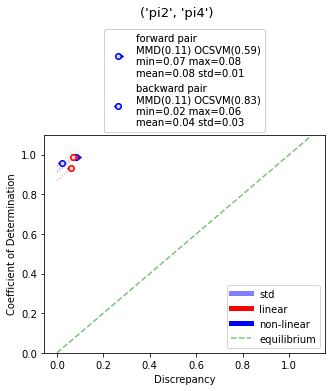

Experiment 2


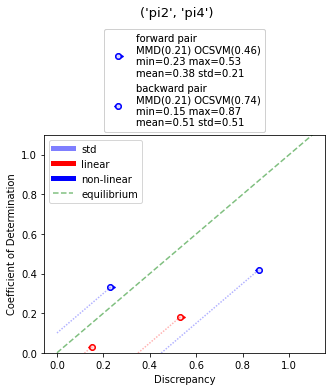

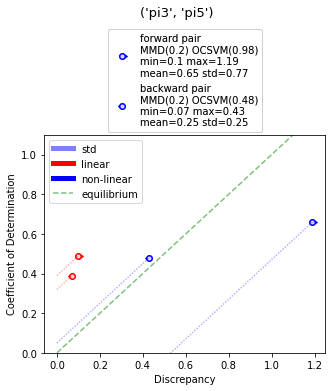

Experiment 3


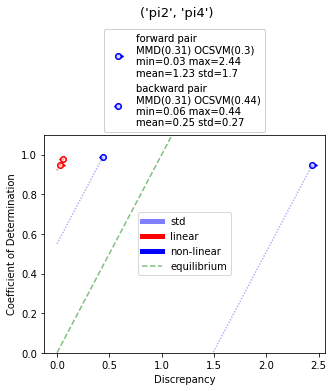

Experiment 1


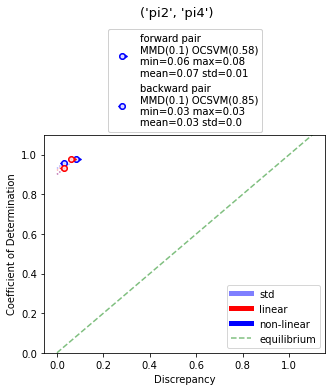

Experiment 2


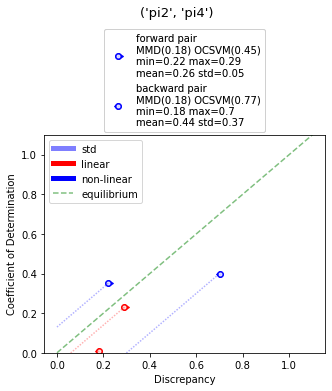

Experiment 3


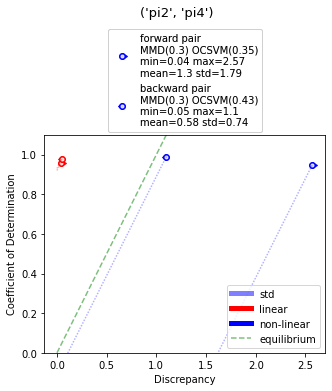

Experiment 1


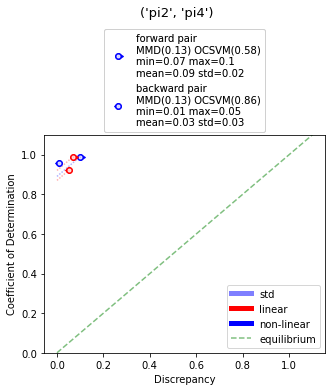

Experiment 2


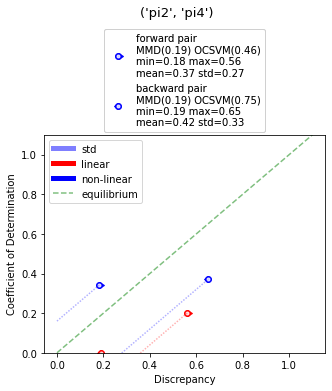

Experiment 3


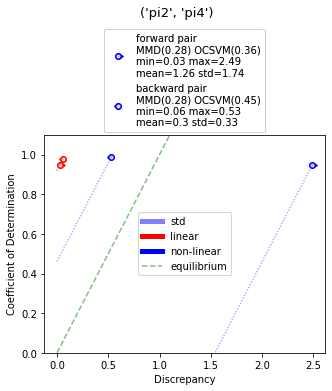

Experiment 1


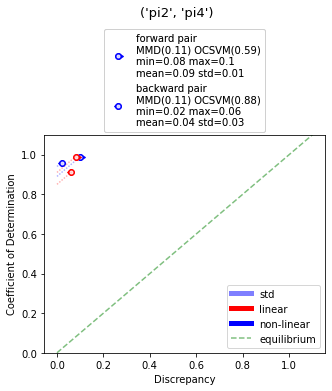

Experiment 2


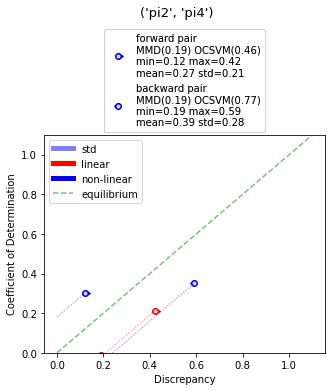

Experiment 3


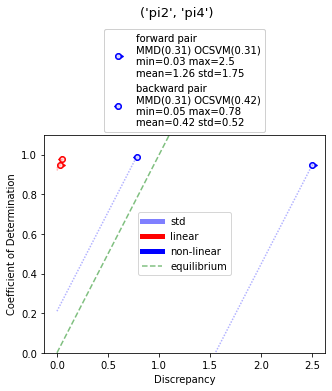

In [7]:
for i in range(1,5):
    sample_id = f"sample_{i}"
    sample_1 = pd.read_csv(f"results/original/{sample_id}.csv") 
    sample_1_stats = plot_r2_discrpenacy(sample_id, sample_1)

In [6]:
data = []
for data_type in ["original", "standardised"]:
    sample_data = []
    for i in range(1,101):
        filename = f"results/{data_type}/sample_{i}.csv"
        sample = pd.read_csv(filename)
        sample["sample"] = i
        sample_data.append(sample)
    data.append(pd.concat(sample_data, ignore_index = True))

In [7]:
merged_data = []
for dataset in data:
    experiment_merged_dfs = []
    for exp in range(1,4):
        df = dataset.loc[(dataset.experiment == exp)]
        similar_pairs = find_similar_pairs(df)
        for x,y in similar_pairs:
            for kernel in ["rbf", "linear"]:
                pair_df = df.loc[(df.model_node == x) & (df.test_node==y) & (df.kernel == kernel)]
                mean_data = pair_df.mean().round(2)
                merged_df = pd.DataFrame(columns=mean_data.index.values)
                merged_df.loc[0] = mean_data.values
                merged_df.round(1)
                merged_df["model_node"] = x
                merged_df ["test_node"] = y
                merged_df["std"] = df["std"].values[0]
                merged_df["experiment"] = exp
                merged_df["kernel"] = kernel
                experiment_merged_dfs.append(merged_df)
    merged_data.append(pd.concat(experiment_merged_dfs, ignore_index=True))

In [143]:
for i in range(2):
    print(std[i])
    for experiment in range(1,4):
        print(f"Experiment {experiment}", end=" ")
        df = data[i].loc[(data[i].experiment == experiment)]
        unique_nodes = np.unique(df["model_node"])
        for node in unique_nodes:
            average_baseline_score = df["model_r2"].loc[df.model_node == node].mean()
            print(f"{node} ({round(average_baseline_score, 2)})", end = " ")
        print()
    print()

standardised
Experiment 1 pi2 (0.99) pi4 (0.93) 
Experiment 2 pi2 (0.27) pi3 (0.56) pi4 (0.18) pi5 (0.38) 
Experiment 3 pi2 (0.95) pi4 (0.99) 

original
Experiment 1 pi2 (0.99) pi3 (0.95) pi4 (0.93) 
Experiment 2 pi2 (0.29) pi3 (0.57) pi5 (0.36) 
Experiment 3 pi2 (0.95) pi4 (0.99) 



Experiment 1


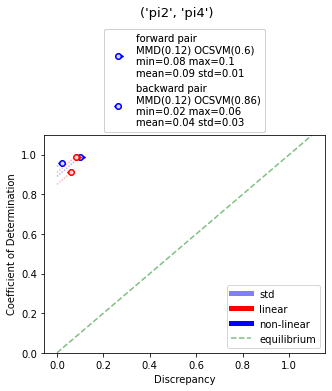

Experiment 2


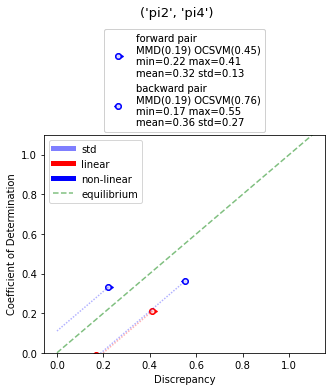

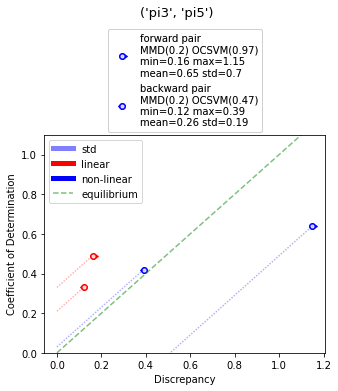

Experiment 3


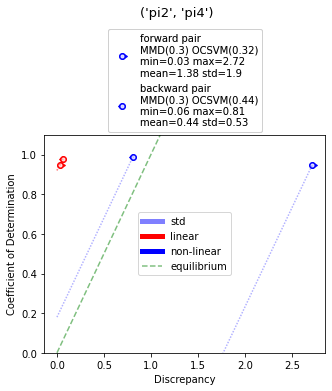

In [16]:
plot_r2_discrpenacy(merged_data[0])

Experiment 1


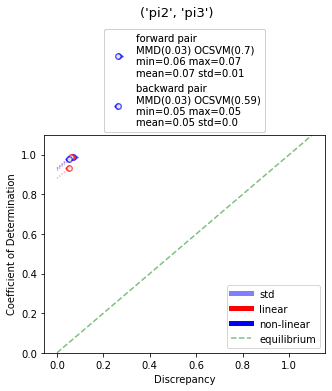

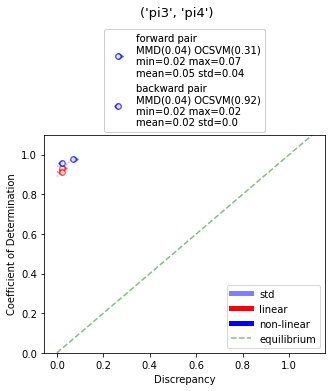

Experiment 2


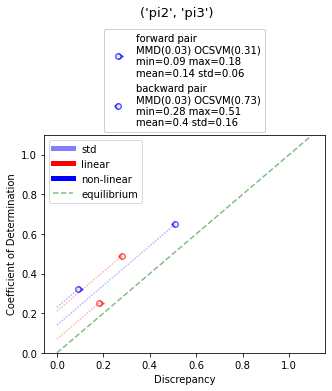

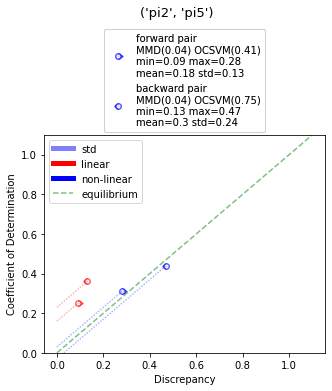

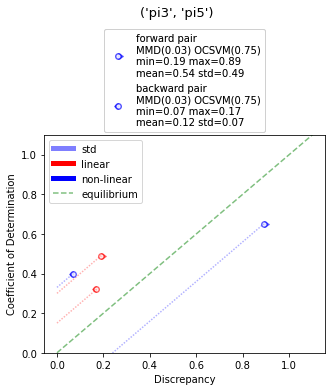

Experiment 3


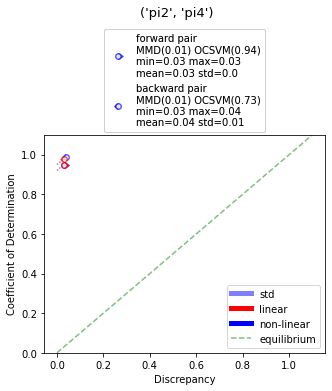

In [17]:
plot_r2_discrpenacy(merged_data[1])

In [190]:
def find_the_best_entry_per_sample(df):
    results = pd.DataFrame()
    for experiment in range(1,4):
        for sample in range(1,101):
            exp = df.loc[(df.experiment == experiment) & (df["sample"] == sample)]
            similar_pairs = find_similar_pairs(exp)
            for x,y in similar_pairs[::2]:
                pair_df = exp.loc[((exp.model_node == x) & (exp.test_node == y))|((exp.model_node ==y) & (exp.test_node == x))]
                max_entry = pair_df.loc[pair_df["model_r2-d"].idxmax()]
                results = pd.concat([results, max_entry.to_frame().T])
    return results

In [226]:
def ocsvm_correct(df, strict):
    if strict:
        max_pairs = df.loc[df["model_r2-d"] == df["model_r2-d"].max()]
    else:
        max_pairs = df.loc[df["model_r2-d"] > df["model_r2-d"].max() - 0.05]
    
    if df["ocsvm_score"].max() in max_pairs["ocsvm_score"].values:
        return 1
    else: 
        return 0

def mmd_correct(df, threshold):
    max_pairs = df.loc[df["model_r2-d"] == df["model_r2-d"].max()]
    drop = (max_pairs.loc[:, "model_r2-d"]/max_pairs.loc[:,"test_r2"]).min()
    if drop > threshold:
        return 1
    else: 
        return 0

def method_correct(df, strict, threshold):
    if strict:
        max_pairs = df.loc[df["model_r2-d"] == df["model_r2-d"].max()]
    else:
        max_pairs = df.loc[df["model_r2-d"] > df["model_r2-d"].max() - 0.05]
    
    correct = 0
    if df["ocsvm_score"].max() in max_pairs["ocsvm_score"].values:
        best_entry = max_pairs.loc[max_pairs["ocsvm_score"].idxmax()]
        drop = best_entry.loc["model_r2-d"]/best_entry.loc["test_r2"]
        if drop > threshold:
            correct = 1
    return correct

def accuracy(df, accuracy_args):
    exp_accuracy = []
    for experiment in range(1,4):
        correct = 0
        for sample in range(1,101):
            sample_correct = 0
            exp = df.loc[(df.experiment == experiment) & (df["sample"] == sample)]
            similar_pairs = find_similar_pairs(exp)
            for x,y in similar_pairs[::2]:
                pair_df = exp.loc[((exp.model_node == x) & (exp.test_node == y))|((exp.model_node ==y) & (exp.test_node == x))]
                if isinstance(accuracy_args, list):
                    sample_correct += method_correct(pair_df, strict = accuracy_args[0], threshold = accuracy_args[1])
                elif isinstance(accuracy_args, bool):
                    sample_correct += ocsvm_correct(pair_df, strict = accuracy_args)
                else:
                    sample_correct += mmd_correct(pair_df, threshold = accuracy_args)
            correct += sample_correct/len(similar_pairs[::2])
        exp_accuracy.append(round(correct/100,2))
    weights = [df.loc[df.experiment == experiment].shape[0]/df.shape[0] for experiment in range(1,4)]
    weighted_avg_accuracy = sum([weights[i] * exp_accuracy[i] for i in range(3)])
    avg_accuracy = sum(exp_accuracy)/3
    return exp_accuracy, round(weighted_avg_accuracy,2), round(avg_accuracy,2)

In [ ]:
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    print(threshold)
    for strict in [True, False]:
        for i in range(2):
            if data[i]["std"].values[0]:
                kernel = "rbf"
            else:
                kernel = "linear"
            print(f"{std[i]} {kernel} strict : {strict}", accuracy(data[i].loc[data[i].kernel ==kernel], [strict, threshold]))
        print()

0.5
standardised linear strict : True ([1.0, 0.67, 0.68], 0.77, 0.78)
original rbf strict : True ([0.49, 0.21, 1.0], 0.48, 0.57)

standardised linear strict : False ([1.0, 0.69, 1.0], 0.86, 0.9)
original rbf strict : False ([1.0, 0.22, 1.0], 0.69, 0.74)

0.6
standardised linear strict : True ([1.0, 0.58, 0.68], 0.73, 0.75)
original rbf strict : True ([0.49, 0.14, 1.0], 0.46, 0.54)

standardised linear strict : False ([1.0, 0.61, 1.0], 0.83, 0.87)
original rbf strict : False ([1.0, 0.14, 1.0], 0.66, 0.71)

0.7
standardised linear strict : True ([1.0, 0.49, 0.68], 0.69, 0.72)
original rbf strict : True ([0.49, 0.08, 1.0], 0.43, 0.52)

standardised linear strict : False ([1.0, 0.53, 1.0], 0.79, 0.84)
original rbf strict : False ([1.0, 0.09, 1.0], 0.64, 0.7)

0.8
standardised linear strict : True ([1.0, 0.33, 0.68], 0.62, 0.67)
original rbf strict : True ([0.49, 0.02, 1.0], 0.41, 0.5)



In [200]:
## per kernel
for strict in [True, False]:
    for i in range(2):
        for kernel in kernels:
            print(f"{std[i]} {kernel} strict : {strict}", accuracy(data[i].loc[data[i].kernel ==kernel], strict))
    print()

standardised linear strict : True ([1.0, 0.71, 0.68], 0.78, 0.8)
standardised rbf strict : True ([1.0, 0.02, 1.0], 0.57, 0.67)
original linear strict : True ([0.24, 0.32, 1.0], 0.43, 0.52)
original rbf strict : True ([0.49, 0.31, 1.0], 0.52, 0.6)

standardised linear strict : False ([1.0, 0.74, 1.0], 0.89, 0.91)
standardised rbf strict : False ([1.0, 0.07, 1.0], 0.59, 0.69)
original linear strict : False ([0.64, 0.32, 1.0], 0.59, 0.65)
original rbf strict : False ([1.0, 0.32, 1.0], 0.73, 0.77)



In [202]:
for strict in [True, False]:
    for i in range(2):
        print(f"{std[i]} strict : {strict}", accuracy(data[i], strict))
    print()

standardised strict : True ([1.0, 0.53, 0.68], 0.7, 0.74)
original strict : True ([0.46, 0.32, 1.0], 0.52, 0.59)

standardised strict : False ([1.0, 0.72, 1.0], 0.88, 0.91)
original strict : False ([0.64, 0.32, 1.0], 0.59, 0.65)



In [205]:
## per kernel
for i in range(2):
    for threshold in [0.85, 0.9, 0.95]:
        for kernel in kernels:
            print(std[i], kernel, threshold, accuracy(data[i].loc[data[i].kernel ==kernel], threshold))
    print()

standardised linear 0.85 ([1.0, 0.51, 1.0], 0.79, 0.84)
standardised rbf 0.85 ([1.0, 0.0, 0.0], 0.28, 0.33)
standardised linear 0.9 ([1.0, 0.34, 1.0], 0.71, 0.78)
standardised rbf 0.9 ([1.0, 0.0, 0.0], 0.28, 0.33)
standardised linear 0.95 ([1.0, 0.12, 0.73], 0.54, 0.62)
standardised rbf 0.95 ([0.66, 0.0, 0.0], 0.19, 0.22)

original linear 0.85 ([1.0, 0.96, 1.0], 0.98, 0.99)
original rbf 0.85 ([1.0, 0.01, 1.0], 0.6, 0.67)
original linear 0.9 ([1.0, 0.53, 1.0], 0.81, 0.84)
original rbf 0.9 ([1.0, 0.0, 1.0], 0.6, 0.67)
original linear 0.95 ([1.0, 0.47, 1.0], 0.79, 0.82)
original rbf 0.95 ([0.49, 0.0, 1.0], 0.4, 0.5)



In [127]:
for i in range(2):
    print(std[i])
    for threshold in [0.85, 0.9, 0.95]:
        print(threshold, accuracy(data[i], threshold))

standardised
0.85 ([1.0, 0.44, 1.0], 0.75, 0.81)
0.9 ([1.0, 0.32, 1.0], 0.7, 0.77)
0.95 ([1.0, 0.1, 0.73], 0.53, 0.61)
original
0.85 ([1.0, 0.69, 1.0], 0.88, 0.9)
0.9 ([1.0, 0.45, 1.0], 0.78, 0.82)
0.95 ([0.98, 0.39, 1.0], 0.75, 0.79)


In [186]:
def kernel_summary(df, best_entry = False):
    if best_entry:
        df = find_the_best_entry_per_sample(df)
    for experiment in range(1,4):
        rbf = df.loc[(df.experiment == experiment) & (df.kernel == "rbf")]
        linear = df.loc[(df.experiment == experiment) & (df.kernel == "linear")]
        if best_entry:
            print(f"The entries whose model kernel is linear and rbf respectively are {linear.shape[0]}, {rbf.shape[0]} ")
        if rbf.shape[0] == 0:
            baseline_score, lower_discrepancy, best_kernel = "linear", "linear", "linear"
        elif linear.shape[0] == 0:
            baseline_score, lower_discrepancy, best_kernel = "rbf", "rbf", "rbf"
        else:
            if rbf.model_r2.mean() > linear.model_r2.mean():
                baseline_score = "rbf"
            else:
                baseline_score = "linear"
            if rbf.discrepancy.mean() > linear.discrepancy.mean():
                lower_discrepancy = "linear"
            else:
                lower_discrepancy = "rbf"
            if rbf["model_r2-d"].mean() > linear["model_r2-d"].mean():
                best_kernel = "rbf"
            else:
                best_kernel = "linear"
        print(f"In experiment {experiment} {baseline_score} have higher baseline R2 scores", end = " and ")
        print(f"{lower_discrepancy} models have lower discrepancy", end = ". \n")
        print(f"Models with {best_kernel} kernel yield the best results on average.")
    print()

In [191]:
kernel_summary(data[0])
kernel_summary(data[0], best_entry=True)

In experiment 1 rbf have higher baseline R2 scores and rbf models have lower discrepancy. 
Models with linear kernel yield the best results on average.
In experiment 2 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.
In experiment 3 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.

The entries whose model kernel is linear and rbf respectively are 100, 0 
In experiment 1 linear have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.
The entries whose model kernel is linear and rbf respectively are 128, 28 
In experiment 2 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.
The entries whose model kernel is linear and rbf respectively are 100, 0 
I

In [192]:
kernel_summary(data[1])
kernel_summary(data[1], best_entry = True)

In experiment 1 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.
In experiment 2 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.
In experiment 3 rbf have higher baseline R2 scores and linear models have lower discrepancy. 
Models with linear kernel yield the best results on average.

The entries whose model kernel is linear and rbf respectively are 102, 90 
In experiment 1 rbf have higher baseline R2 scores and rbf models have lower discrepancy. 
Models with linear kernel yield the best results on average.
The entries whose model kernel is linear and rbf respectively are 140, 54 
In experiment 2 rbf have higher baseline R2 scores and rbf models have lower discrepancy. 
Models with linear kernel yield the best results on average.
The entries whose model kernel is linear and rbf respectively are 49, 51 
In exp

In [ ]:
# for data_type in ["original", "standardised"]:
#     for i in range(1,5):
#         filename = f"results/{data_type}/sample_{i}.csv"
#         sample = pd.read_csv(filename)
#         sample["r2-d"] = sample["r2"] - sample["discrepancy"]
#         kernels = []
#         for model in sample.model.values:
#             if "linear" in model:
#                 kernel = "linear"
#             else:
#                 kernel = "rbf"
#             kernels.append(kernel)
#         sample["kernel"] = kernels
#         sample.to_csv(filename)